In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Praktikum9") \
    .getOrCreate()

data = [
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1)
]
columns = ['Name', 'Age', 'Gender', 'Salary', 'DeptId']
df = spark.createDataFrame(data, schema=columns)
df.createOrReplaceTempView('employees')
spark.sql('SELECT * FROM employees').show()
spark.sql('SELECT Name, Age FROM employees WHERE Salary > 3000').show()
spark.sql('SELECT AVG(Salary) FROM employees').show()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/10/24 17:31:39 WARN Utils: Your hostname, jaki-ThinkPad-T490, resolves to a loopback address: 127.0.1.1; using 192.168.1.85 instead (on interface wlp0s20f3)
25/10/24 17:31:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/24 17:31:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/10/24 17:31:41 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
                                                                                

+-----+---+------+------+------+
| Name|Age|Gender|Salary|DeptId|
+-----+---+------+------+------+
|James| 34|     M|  3000|     1|
| Anna| 28|     F|  4100|     2|
|  Lee| 23|     M|  2700|     1|
+-----+---+------+------+------+

+----+---+
|Name|Age|
+----+---+
|Anna| 28|
+----+---+

+------------------+
|       avg(Salary)|
+------------------+
|3266.6666666666665|
+------------------+



In [3]:
# Total gaji berdasarkan jenis kelamin dan usia.
spark.sql('''
SELECT Gender, SUM(Salary) as TotalSalary, Age
FROM employees
GROUP BY Gender, Age
ORDER BY Age
''').show()

# 1. Rata-rata gaji per departemen
spark.sql('''
SELECT DeptId,
       AVG(Salary) AS AvgSalary
FROM employees
GROUP BY DeptId
ORDER BY DeptId
''').show()

# 2. Karyawan dengan gaji di atas rata-rata untuk gender masing-masing
spark.sql('''
SELECT Name, Gender, Salary
FROM (
    SELECT Name, Gender, Salary,
           AVG(Salary) OVER (PARTITION BY Gender) AS AvgSalaryGender
    FROM employees
)
WHERE Salary > AvgSalaryGender
ORDER BY Gender, Salary DESC
''').show()

# 3. Ranking karyawan berdasarkan gaji dalam departemen mereka
spark.sql('''
SELECT Name, DeptId, Salary,
       RANK() OVER (PARTITION BY DeptId ORDER BY Salary DESC) AS Rank
FROM employees
ORDER BY DeptId, Rank
''').show()

+------+-----------+---+
|Gender|TotalSalary|Age|
+------+-----------+---+
|     M|       2700| 23|
|     F|       4100| 28|
|     M|       3000| 34|
+------+-----------+---+

+------+---------+
|DeptId|AvgSalary|
+------+---------+
|     1|   2850.0|
|     2|   4100.0|
+------+---------+

+-----+------+------+
| Name|Gender|Salary|
+-----+------+------+
|James|     M|  3000|
+-----+------+------+

+-----+------+------+----+
| Name|DeptId|Salary|Rank|
+-----+------+------+----+
|James|     1|  3000|   1|
|  Lee|     1|  2700|   2|
| Anna|     2|  4100|   1|
+-----+------+------+----+



In [7]:
spark.sql('''
SELECT Name, Age, Salary, Rank
FROM (
    SELECT Name, Age, Salary,
           ROW_NUMBER() OVER (PARTITION BY Age ORDER BY Salary DESC) AS Rank
    FROM employees
)
WHERE Rank <= 3
ORDER BY Age, Rank
''').show()

+-----+---+------+----+
| Name|Age|Salary|Rank|
+-----+---+------+----+
|  Lee| 23|  2700|   1|
| Anna| 28|  4100|   1|
|James| 34|  3000|   1|
+-----+---+------+----+



In [13]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Praktikum9').getOrCreate()

# Data setup for complex SQL queries
employees = spark.createDataFrame([
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1),
    ('Jaki aja lah', 23, 'M', 5000, 2)
], ['Name', 'Age', 'Gender', 'Salary', 'DeptId'])
departments = spark.createDataFrame([
    (1, 'HR'),
    (2, 'Marketing')
], ['DeptId', 'DeptName'])
projects = spark.createDataFrame([
    (1, 'Project A'),
    (2, 'Project B')
], ['DeptId', 'ProjectName'])
employees.createOrReplaceTempView('employees')
departments.createOrReplaceTempView('departments')
projects.createOrReplaceTempView('projects')

# Complex SQL query involving multiple joins and subqueries
spark.sql('''
SELECT e.Name, e.Age, d.DeptName, p.ProjectName
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
JOIN projects p ON e.DeptId = p.DeptId
''').show()

+------------+---+---------+-----------+
|        Name|Age| DeptName|ProjectName|
+------------+---+---------+-----------+
|         Lee| 23|       HR|  Project A|
|       James| 34|       HR|  Project A|
|Jaki aja lah| 23|Marketing|  Project B|
|        Anna| 28|Marketing|  Project B|
+------------+---+---------+-----------+



In [5]:
spark.sql('''
SELECT 
    e.Name,
    e.DeptId,
    e.Salary,
    AVG(e.Salary) OVER (PARTITION BY e.DeptId) AS AvgSalaryDept,
    RANK() OVER (PARTITION BY e.DeptId ORDER BY e.Salary DESC) AS RankInDept
FROM employees e
ORDER BY e.DeptId, RankInDept
''').show()

+-----+------+------+-------------+----------+
| Name|DeptId|Salary|AvgSalaryDept|RankInDept|
+-----+------+------+-------------+----------+
|James|     1|  3000|       2850.0|         1|
|  Lee|     1|  2700|       2850.0|         2|
| Anna|     2|  4100|       4100.0|         1|
+-----+------+------+-------------+----------+



In [6]:
spark.sql('''
SELECT 
    e.DeptId,
    e.Age,
    e.Salary,
    AVG(e.Salary) OVER (PARTITION BY e.DeptId ORDER BY e.Age ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS SalaryTrend
FROM employees e
ORDER BY e.DeptId, e.Age
''').show()

+------+---+------+-----------+
|DeptId|Age|Salary|SalaryTrend|
+------+---+------+-----------+
|     1| 23|  2700|     2700.0|
|     1| 34|  3000|     2850.0|
|     2| 28|  4100|     4100.0|
+------+---+------+-----------+



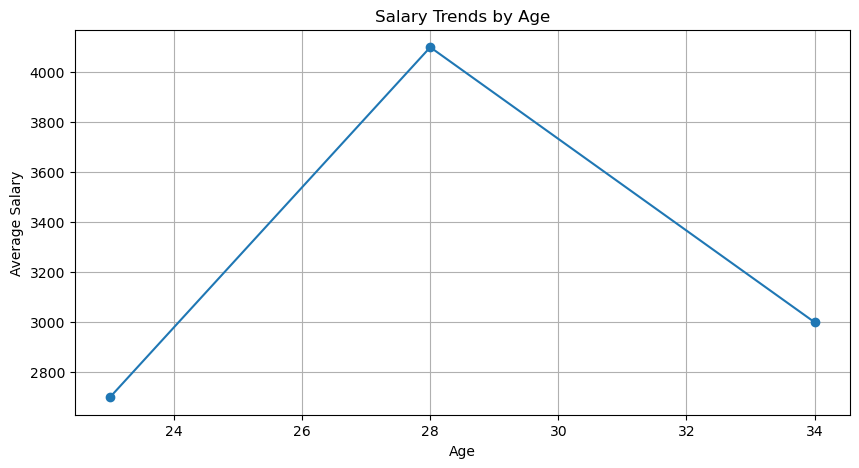

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Advanced data analysis with visualization
salary_trends = spark.sql('''
SELECT Age, AVG(Salary) AS AverageSalary
FROM employees
GROUP BY Age
ORDER BY Age
''').toPandas()

# Visualization of salary trends
plt.figure(figsize=(10, 5))
plt.plot(salary_trends['Age'], salary_trends['AverageSalary'], marker='o')
plt.xlabel('Age')
plt.ylabel('Average Salary')
plt.title('Salary Trends by Age')
plt.grid(True)
plt.show()


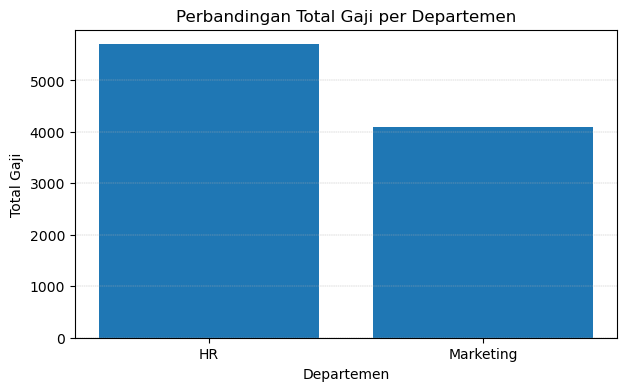

In [10]:
# Total gaji dan jumlah karyawan per departemen
agg_dept = spark.sql('''
SELECT d.DeptName,
       SUM(e.Salary) AS TotalSalary,
       COUNT(e.Name) AS NumEmployees,
       ROUND(AVG(e.Salary),2) AS AvgSalary
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
GROUP BY d.DeptName
ORDER BY TotalSalary DESC
''')

# Konversi ke pandas untuk plotting
agg_dept_pd = agg_dept.toPandas()

# Bar chart Total Salary per Dept
plt.figure(figsize=(7,4))
plt.bar(agg_dept_pd['DeptName'], agg_dept_pd['TotalSalary'])
plt.xlabel('Departemen')
plt.ylabel('Total Gaji')
plt.title('Perbandingan Total Gaji per Departemen')
plt.grid(axis='y', linestyle='--', linewidth=0.3)
plt.show()

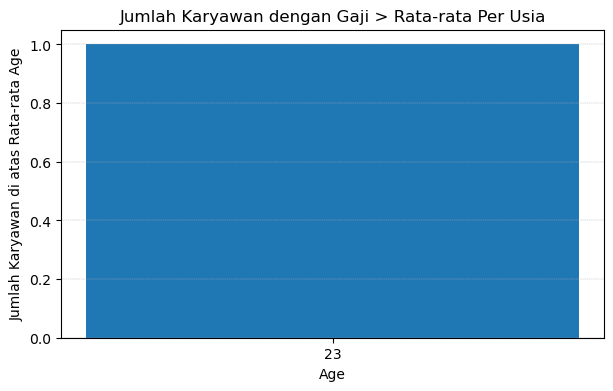

In [15]:
# Cari karyawan yang gajinya di atas rata-rata untuk kelompok usia (Age)
above_age_avg = spark.sql('''
SELECT Name, Age, Salary
FROM (
    SELECT Name, Age, Salary,
           AVG(Salary) OVER (PARTITION BY Age) AS AvgSalaryByAge
    FROM employees
) t
WHERE Salary > AvgSalaryByAge
ORDER BY Age, Salary DESC
''')

# Konversi hasil ke pandas untuk visualisasi
above_age_pd = above_age_avg.toPandas()

# Jika ada data, buat bar chart jumlah karyawan per Age yang di atas rata-rata
if not above_age_pd.empty:
    count_by_age = above_age_pd.groupby('Age').size().reset_index(name='CountAboveAvg')
    plt.figure(figsize=(7,4))
    plt.bar(count_by_age['Age'].astype(str), count_by_age['CountAboveAvg'])
    plt.xlabel('Age')
    plt.ylabel('Jumlah Karyawan di atas Rata-rata Age')
    plt.title('Jumlah Karyawan dengan Gaji > Rata-rata Per Usia')
    plt.grid(axis='y', linestyle='--', linewidth=0.3)
    plt.show()
else:
    print("Tidak ada karyawan yang gaji di atas rata-rata per usia pada dataset ini.")


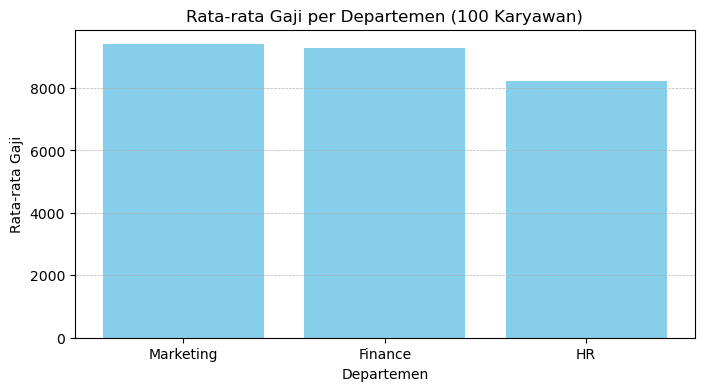

NameError: name 'emp_pd' is not defined

<Figure size 800x500 with 0 Axes>

In [19]:
from pyspark.sql import SparkSession
import random
import matplotlib.pyplot as plt
import pandas as pd

# Inisialisasi SparkSession
spark = SparkSession.builder.appName("Tugas3_Analisis100Baris").getOrCreate()

# Generate dataset dummy (100 baris) ---
random.seed(42)
num_rows = 100
names = [f'Emp{str(i).zfill(3)}' for i in range(1, num_rows+1)]
genders = ['M', 'F']
dept_ids = [1, 2, 3]
departments = spark.createDataFrame([
    (1, 'HR'),
    (2, 'Marketing'),
    (3, 'Finance')
], ['DeptId', 'DeptName'])

data = []
for i in range(num_rows):
    name = names[i]
    age = random.randint(21, 60)
    gender = random.choice(genders)
    salary = random.randint(3000, 15000)
    deptid = random.choice(dept_ids)
    data.append((name, age, gender, salary, deptid))

employees = spark.createDataFrame(data, ['Name','Age','Gender','Salary','DeptId'])

# Register views
employees.createOrReplaceTempView('employees')
departments.createOrReplaceTempView('departments')

# Analisis SQL: agregasi per departemen ---
summary = spark.sql('''
SELECT d.DeptName,
       COUNT(e.Name) AS JumlahKaryawan,
       SUM(e.Salary) AS TotalGaji,
       ROUND(AVG(e.Salary),2) AS RataRataGaji,
       MIN(e.Salary) AS GajiTerkecil,
       MAX(e.Salary) AS GajiTerbesar
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
GROUP BY d.DeptName
ORDER BY RataRataGaji DESC
''')

# Bar chart rata-rata gaji per departemen ---
summary_pd = summary.toPandas()
plt.figure(figsize=(8,4))
plt.bar(summary_pd['DeptName'], summary_pd['RataRataGaji'], color='skyblue')
plt.xlabel('Departemen')
plt.ylabel('Rata-rata Gaji')
plt.title('Rata-rata Gaji per Departemen (100 Karyawan)')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()

plt.figure(figsize=(8,5))
emp_pd.boxplot(column='Salary', by='DeptName', grid=False)
plt.title('Distribusi Gaji per Departemen')
plt.suptitle('')
plt.xlabel('Departemen')
plt.ylabel('Gaji')
plt.show()
